In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv(r'/Users/battih/Desktop/Personal/demand-forecasting-walmart/data/processed/base_dataset.csv', parse_dates=['Date'])

In [2]:
series = (
    df[(df['Store']==1)&(df['Dept']==1)]
    .sort_values('Date')
    .reset_index(drop=True)
)

series.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [3]:
split_idx = int(len(series)*0.8)

train = series.iloc[:split_idx]
test = series.iloc[split_idx:]

train.shape, test.shape

((114, 17), (29, 17))

In [5]:
pip install scikit-learn

  Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl (8.0 MB)
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

def evaluate_forecast(y_true, y_pred):
    return{
        'MAE':mean_absolute_error(y_true, y_pred),
        'RMSE':root_mean_squared_error(y_true,y_pred)
    }

In [11]:
naive_pred = np.repeat(train['Weekly_Sales'].iloc[-1], len(test))

evaluate_forecast(test['Weekly_Sales'], naive_pred)

{'MAE': 38821.625517241395, 'RMSE': 39029.00549363618}

In [12]:
window = 4
ma_value = train['Weekly_Sales'].tail(window).mean()
ma_pred = np.repeat(ma_value, len(test))
evaluate_forecast(test['Weekly_Sales'], ma_pred)

{'MAE': 14117.452068965518, 'RMSE': 14550.188315069898}

In [13]:
seasonal_lag = 52

seasonal_pred = []

for i in range(len(test)):
    idx = split_idx + i -seasonal_lag
    if idx >= 0:
        seasonal_pred.append(series.iloc[idx]['Weekly_Sales'])
    else:
        seasonal_pred.append(train['Weekly_Sales'].iloc[-1])

seasonal_pred = np.array(seasonal_pred)

evaluate_forecast(test['Weekly_Sales'], seasonal_pred)

{'MAE': 3494.893793103448, 'RMSE': 8030.703406598006}

In [14]:
results = pd.DataFrame([
    {'Model':'Naive', **evaluate_forecast(test['Weekly_Sales'], naive_pred)},
    {'Model':'Moving Average (4)', **evaluate_forecast(test['Weekly_Sales'], ma_pred)},
    {'Model':'Seasonal Naive', **evaluate_forecast(test['Weekly_Sales'], seasonal_pred)}
])

results

,Model,MAE,RMSE
0,Naive,38821.625517,39029.005494
1,Moving Average (4),14117.452069,14550.188315
2,Seasonal Naive,3494.893793,8030.703407


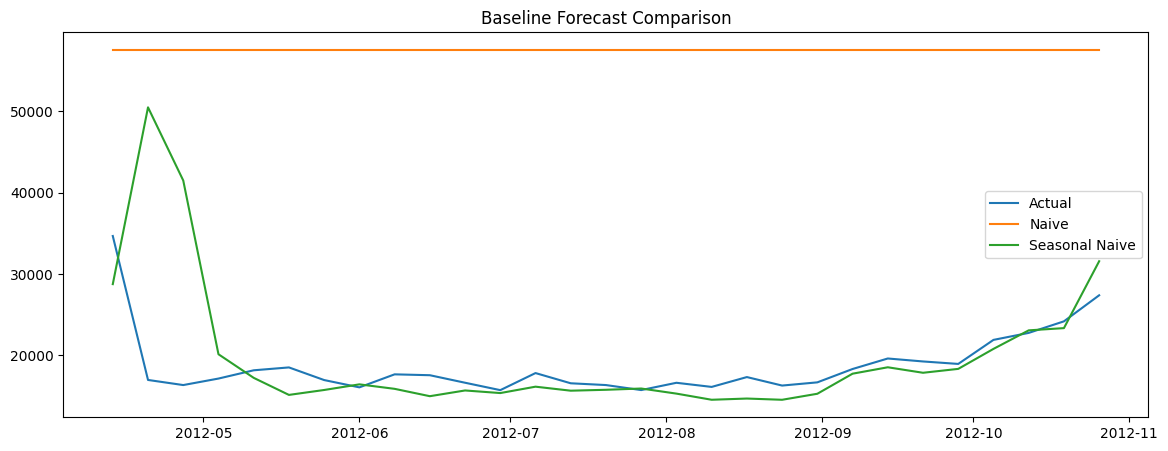

In [15]:
plt.figure(figsize=(14,5))
plt.plot(test["Date"], test["Weekly_Sales"], label="Actual")
plt.plot(test["Date"], naive_pred, label="Naive")
plt.plot(test["Date"], seasonal_pred, label="Seasonal Naive")
plt.legend()
plt.title("Baseline Forecast Comparison")
plt.show()
